In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [11]:
def Rx(deg):
    theta = np.deg2rad(deg)
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([
        [1, 0, 0],
        [0, c, -s],
        [0, s, c]
    ])

def Ry(deg):
    theta = np.deg2rad(deg)
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([
        [c, 0, s],
        [0, 1, 0],
        [-s, 0, c]
    ])

def Rz(deg):
    theta = np.deg2rad(deg)
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([
        [c, -s, 0],
        [s, c, 0],
        [0, 0, 1]
    ])

def T(R, p):
    M = np.eye(4)
    M[0:3, 0:3] = R
    M[0:3, 3] = p
    return M

In [12]:
def skew(w):
    return np.array([
        [0,      -w[2],  w[1]],
        [w[2],   0,     -w[0]],
        [-w[1],  w[0],   0]
    ])

def screw_axis(w, q):
    v = -np.cross(w, q)
    return np.hstack((w, v))

In [13]:
def matrix_exp6(xi):
    w = xi[:3].astype(float)
    v = xi[3:].astype(float)
    theta = np.linalg.norm(w)

    if theta < 1e-9:
        T_mat = np.eye(4)
        T_mat[:3, 3] = v
        return T_mat

    w_unit = w / theta
    w_hat = skew(w_unit)
    R = np.eye(3) + math.sin(theta) * w_hat + (1 - math.cos(theta)) * (w_hat @ w_hat)
    # G matrix
    G = (np.eye(3) * theta + (1 - math.cos(theta)) * w_hat + (theta - math.sin(theta)) * (w_hat @ w_hat))
    p = (G @ v) / theta
    T_mat = np.eye(4)
    T_mat[:3, :3] = R
    T_mat[:3, 3] = p
    return T_mat

def adjoint(T_mat):
    R = T_mat[0:3, 0:3]
    p = T_mat[0:3, 3]
    p_skew = skew(p)
    return np.block([
        [R,                np.zeros((3, 3))],
        [p_skew @ R,       R]
    ])

def so3_log(R):
    cos_theta = (np.trace(R) - 1) / 2.0
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.arccos(cos_theta)
    if abs(theta) < 1e-8:
        return np.zeros(3), 0.0
    w_hat = (R - R.T) / (2.0 * np.sin(theta))
    w = np.array([w_hat[2,1], w_hat[0,2], w_hat[1,0]])
    return w, theta

def se3_log(T_mat):
    R = T_mat[0:3, 0:3]
    p = T_mat[0:3, 3]
    w, theta = so3_log(R)

    if abs(theta) < 1e-8:
        return np.hstack((np.zeros(3), p))

    w_hat = skew(w)
    A_inv = (np.eye(3) / theta
             - 0.5 * w_hat
             + (1.0/theta - 0.5/np.tan(theta/2.0)) * (w_hat @ w_hat))
    v = A_inv @ p
    return np.hstack((w * theta, v * theta))

In [14]:
# link offsets (meters)
d1 = 169.5 / 1000.0
d3 = 115.5 / 1000.0
d5 = 127.83 / 1000.0
d7 = 65.98 / 1000.0

w1 = np.array([0., 0., 1.])
w2 = np.array([0., 1., 0.])
w3 = np.array([0., 0., 1.])
w4 = np.array([1., 0., 0.])
w5 = np.array([0., 0., 1.])
w6 = np.array([1., 0., 0.])
w7 = np.array([0., 0., 1.])

q1 = np.array([0.0, 0.0, 0.0])
q2 = np.array([0.0, 0.0, d1])
q3 = np.array([0.0, 0.0, d1 + d3])
q4 = np.array([0.0, 0.0, d1 + d3])
q5 = np.array([0.0, 0.0, d1 + d3 + d5])
q6 = np.array([0.0, 0.0, d1 + d3 + d5])
q7 = np.array([0.0, 0.0, d1 + d3 + d5 + d7])

S1 = screw_axis(w1, q1)
S2 = screw_axis(w2, q2)
S3 = screw_axis(w3, q3)
S4 = screw_axis(w4, q4)
S5 = screw_axis(w5, q5)
S6 = screw_axis(w6, q6)
S7 = screw_axis(w7, q7)

S_list = np.column_stack((S1, S2, S3, S4, S5, S6, S7))

JOINT_LIMITS = np.deg2rad(np.array([
    [-160.0, 160.0],
    [-70.0, 115.0],
    [-170.0, 170.0],
    [-113.0, 75.0],
    [-170.0, 170.0],
    [-115.0, 115.0],
    [-180.0, 180.0]
]))

In [15]:
def fk_poe(S_list, M, theta):
    T_mat = np.eye(4)
    for i in range(S_list.shape[1]):
        T_mat = T_mat @ matrix_exp6(S_list[:, i] * theta[i])
    return T_mat @ M

def space_jacobian(q, S_list, M=None):
    Js = np.zeros((6, 7))
    Js[:, 0] = S_list[:, 0]
    T_mat = matrix_exp6(S_list[:, 0] * q[0])
    Js[:, 1] = adjoint(T_mat) @ S_list[:, 1]
    T_mat = T_mat @ matrix_exp6(S_list[:, 1] * q[1])
    Js[:, 2] = adjoint(T_mat) @ S_list[:, 2]
    T_mat = T_mat @ matrix_exp6(S_list[:, 2] * q[2])
    Js[:, 3] = adjoint(T_mat) @ S_list[:, 3]
    T_mat = T_mat @ matrix_exp6(S_list[:, 3] * q[3])
    Js[:, 4] = adjoint(T_mat) @ S_list[:, 4]
    T_mat = T_mat @ matrix_exp6(S_list[:, 4] * q[4])
    Js[:, 5] = adjoint(T_mat) @ S_list[:, 5]
    T_mat = T_mat @ matrix_exp6(S_list[:, 5] * q[5])
    Js[:, 6] = adjoint(T_mat) @ S_list[:, 6]
    return Js

def project_to_joint_limits(q, dq, limits):
    q = np.asarray(q, dtype=float)
    dq = np.asarray(dq, dtype=float)
    q_next = q + dq
    lower = limits[:, 0]
    upper = limits[:, 1]
    q_next_clipped = np.clip(q_next, lower, upper)
    new_dq = q_next_clipped - q
    return new_dq

In [16]:
def inverse_kinematics_space_basic(T_target, q0, M, joint_limits,
                                   max_iters=50, tol=1e-4, alpha=0.01, verbose=True):
    """
    Space-frame IK προσαρμοσμένο στις εικόνες.
    """
    q = np.array(q0, dtype=float).copy()
    error_history = []

    if verbose:
        print(f"Starting IK Space Basic... Target pos: {T_target[:3,3]}")

    np.set_printoptions(precision=4, suppress=True, linewidth=200, floatmode='fixed')

    for k in range(max_iters):
        T_current = fk_poe(S_list, M, q)
        T_diff = T_target @ np.linalg.inv(T_current)
        Xi = se3_log(T_diff)
        err_norm = np.linalg.norm(Xi)

        error_history.append(err_norm)

        if verbose:
             # Κώδικας από image_3a30d9.png (αν και εκεί είναι στο τέλος, εδώ είναι πιο χρήσιμο στο loop)
             pass

        if err_norm < tol:
            if verbose:
                print(f"Converged at iter {k}: twist_error={err_norm:.6f}")
            return q, {"converged": True, "iterations": k, "errors": error_history}

        # Κλήση Jacobian με τη σειρά ορισμάτων της εικόνας image_3a30d9.png
        J_s = space_jacobian(q, S_list, M)

        # Επίλυση: Συνδυασμός image_3a30d9.png (pinv) και image_3a30df.png (lstsq fallback)
        try:
            # Όπως στην 1η εικόνα:
            dq = np.linalg.pinv(J_s) @ Xi
        except np.linalg.LinAlgError:
            # Fallback όπως στην 2η εικόνα:
            dq = np.linalg.lstsq(J_s, Xi, rcond=None)[0]

        # Μικρότερο βήμα για σταθερότητα
        dq_norm = np.linalg.norm(dq)

        # Χρήση του ορίου 0.5 (από image_3a30df.png) που είναι πιο ασφαλές από το 100
        if dq_norm > 0.5:
            dq = dq * (0.5 / dq_norm)

        # Joint limits enforcement
        dq = project_to_joint_limits(q, dq, joint_limits)

        # Απλό update (από image_3a30d9.png το alpha ορίζεται ως 1.0)
        alpha_step = 1.0
        q = q + alpha_step * dq

    if verbose:
        print(f"Did not converge after {max_iters} iters. Final ||Xi||: {err_norm:.6f}")

    return q, {"converged": False, "iterations": max_iters, "errors": error_history}

> M (Home Height): 0.4788 m

> M (Home Matrix):
 [[1.0000 0.0000 0.0000 0.0000]
 [0.0000 1.0000 0.0000 0.0000]
 [0.0000 0.0000 1.0000 0.4788]
 [0.0000 0.0000 0.0000 1.0000]] 

> Target Pose (Top Grasp):
 [[ 1.0000  0.0000  0.0000  0.1750]
 [ 0.0000 -1.0000 -0.0000  0.0250]
 [ 0.0000  0.0000 -1.0000  0.0500]
 [ 0.0000  0.0000  0.0000  1.0000]] 

Starting IK Space Basic... Target pos: [0.1750 0.0250 0.0500]
Converged at iter 8: twist_error=0.000000

SUCCESS! Converged in 8 iterations.
------------------------------
Final Joint Angles (Degrees):
[-12.73,  68.82, -60.13, -81.36, -44.14, -41.83, -55.14]

Final End Effector Position:
[0.1750 0.0250 0.0500]

Displaying convergence plot...


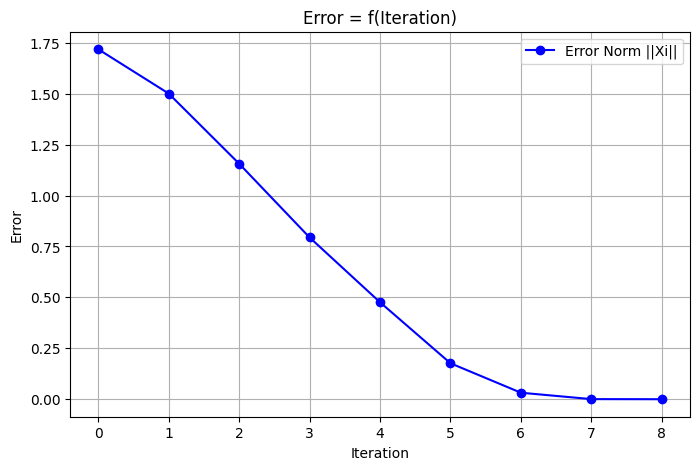

In [17]:
if __name__ == "__main__":
    np.set_printoptions(precision=4, suppress=True, linewidth=200, floatmode='fixed')

    # 1. Υπολογισμός M (Home Pose)
    Rw_ee = np.eye(3)
    pw_ee = np.array([0.0, 0.0, d1 + d3 + d5 + d7])
    M = T(Rw_ee, pw_ee)

    print(f"> M (Home Height): {pw_ee[2]:.4f} m\n")
    print("> M (Home Matrix):\n", M, "\n")

    # 2. Ορισμός Στόχου (Top Grasp)
    target_coords = np.array([17.5, 2.5, 5.0]) / 100.0 # cm -> m
    Rw_target = Rx(180.0) # Κοιτάει κάτω
    Tw_ee_des = T(Rw_target, target_coords)

    print("> Target Pose (Top Grasp):\n", Tw_ee_des, "\n")

    # 3. Αρχική Μαντεψιά
    initial_theta = np.deg2rad([0, 30, 0, -45, 0, -45, 0])

    # 4. Εκτέλεση IK
    ik_q, info = inverse_kinematics_space_basic(
        Tw_ee_des, initial_theta, M, JOINT_LIMITS,
        max_iters=100, tol=1e-4, alpha=1.0, verbose=True
    )

    print("\n" + "="*60)
    if info["converged"]:
        print(f"SUCCESS! Converged in {info['iterations']} iterations.")
        print("-" * 30)
        print("Final Joint Angles (Degrees):")
        print(np.array2string(np.rad2deg(ik_q), precision=2, separator=', '))

        # Verification
        T_final = fk_poe(S_list, M, ik_q)
        print("\nFinal End Effector Position:")
        print(T_final[:3, 3])
    else:
        print("FAILURE: Did not converge.")

    # ================== PLOT ERROR ==================
    if "errors" in info and len(info["errors"]) > 0:
        plt.figure(figsize=(8, 5))
        plt.plot(info["errors"], marker='o', linestyle='-', color='blue', label='Error Norm ||Xi||')

        plt.title('Error = f(Iteration)')
        plt.xlabel('Iteration')
        plt.ylabel('Error')
        plt.grid(True)
        plt.legend()
        print("========================")
        print("\nDisplaying convergence plot...")
        plt.show()


TASK 6: Calculating Placing Position (Approach Hole)
> Target Placing Coordinates: [0.0750 0.0750 0.1000]
> Target Placing Matrix (with 45 deg roll):
 [[ 0.0000  0.7071  0.7071  0.0750]
 [ 0.0000  0.7071 -0.7071  0.0750]
 [-1.0000  0.0000  0.0000  0.1000]
 [ 0.0000  0.0000  0.0000  1.0000]] 

SUCCESS! Placing Pose Converged in 6 iterations.
------------------------------
Final Joint Angles for PLACING (Degrees):
[  52.45,   65.92,  -64.81, -108.25,  -73.47, -114.16,  -90.74]

FK Verification (Position):
Target: [0.0750 0.0750 0.1000]
Actual: [0.0750 0.0750 0.1000]
Position Error: 0.00000 m


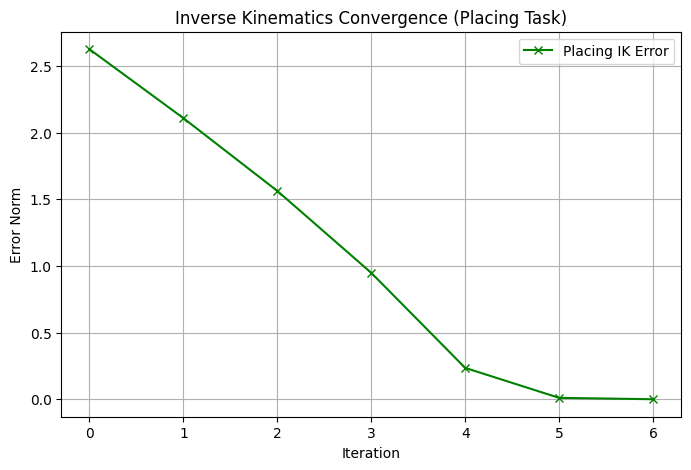

In [18]:
# 6. Task 6: Placing Position (Right next to the hole)
# ====================================================
print("\n" + "="*60)
print("TASK 6: Calculating Placing Position (Approach Hole)")
print("="*60)
z_hole = 10.0 / 100.0
y_hole = target_coords[1] + (5.0 / 100.0)
x_box_surface = 0.175 - (15.0 / 100.0)
standoff = 0.05
x_target = x_box_surface + standoff
p_place = np.array([x_target, y_hole, z_hole])
R_approach = Ry(90.0) @ Rx(45.0)
Tw_ee_place = T(R_approach, p_place)
print(f"> Target Placing Coordinates: {p_place}")
print("> Target Placing Matrix (with 45 deg roll):\n", Tw_ee_place, "\n")
initial_guess_place = ik_q
ik_q_place, info_place = inverse_kinematics_space_basic(
    Tw_ee_place, initial_guess_place, M, JOINT_LIMITS,
    max_iters=100, tol=1e-4, alpha=0.5, verbose=False
)
if info_place["converged"]:
    print(f"SUCCESS! Placing Pose Converged in {info_place['iterations']} iterations.")
    print("-" * 30)
    print("Final Joint Angles for PLACING (Degrees):")
    print(np.array2string(np.rad2deg(ik_q_place), precision=2, separator=', '))
    T_final_place = fk_poe(S_list, M, ik_q_place)
    print("\nFK Verification (Position):")
    print(f"Target: {p_place}")
    print(f"Actual: {T_final_place[:3, 3]}")
    pos_error = np.linalg.norm(p_place - T_final_place[:3, 3])
    print(f"Position Error: {pos_error:.5f} m")
    if "errors" in info_place and len(info_place["errors"]) > 0:
        plt.figure(figsize=(8, 5))
        plt.plot(info_place["errors"], color='green', marker='x', label='Placing IK Error')
        plt.title('Inverse Kinematics Convergence (Placing Task)')
        plt.xlabel('Iteration')
        plt.ylabel('Error Norm')
        plt.grid(True)
        plt.legend()
        plt.show()
else:
      print("FAILURE: Placing IK did not converge.")
      print("Try adjusting the initial guess or the standoff distance.")